Plan:

Train a generative neural language model chapter 7 of nlp book on shopping products dataset.

It should be possible to build a coherent model quickly as the dataset is small and 3-gram model is also coherent.

Use the train model to create fine tuned it on particular product categories like electronics, fashion, etc.

Use these fine tuned models to get a simple bayesian classifier for the product categories. Use the accuracy on the classification task as extrinsic evaluation of the model.

Also train a ngram model on the same dataset and compare the results.

For all models, use the same tokenizer as DistilBERT for fair comparison. Later some pretraining can also 

This notebook prepares the data and trains a simple n-gram model to compute perplexity baselines to beat using gpt-2 fine-tuned models and neural language models

In [47]:
# ml
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# nlp
from nltk.tokenize import word_tokenize
from nltk.util import pad_sequence
from nltk.lm import Vocabulary
from nltk.lm.preprocessing import flatten
from nltk.util import everygrams
from nltk.lm.counter import NgramCounter
import nltk.lm as lm

# deep learning
import torch
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from torch import nn
from datasets import load_dataset
import datasets
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, AutoModel
from transformers import GPT2Tokenizer

# local imports
import importlib
# add '../../deep_learning/src/' to path
import sys
sys.path.insert(1, '../../')
import deep_learning.src.nlp.models as nlp_models
_ = importlib.reload(nlp_models)

import deep_learning.src.nlp.training as nlp_training
_ = importlib.reload(nlp_training)

import deep_learning.src.nlp.preprocessing as local_preprocessing
_ = importlib.reload(local_preprocessing)

import deep_learning.src.nlp.analysis as dl_analysis
_ = importlib.reload(dl_analysis)

import src.experimental_datasets as experimental_datasets
_ = importlib.reload(experimental_datasets)

# basic data analysis
import pandas as pd
import numpy as np
import re, string, os, pickle
from IPython.display import display, HTML
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

Create a baseline using 5-gram language model with witten-bell smoothing.

train has 96526 samples
val has 24132 samples
test has 51710 samples


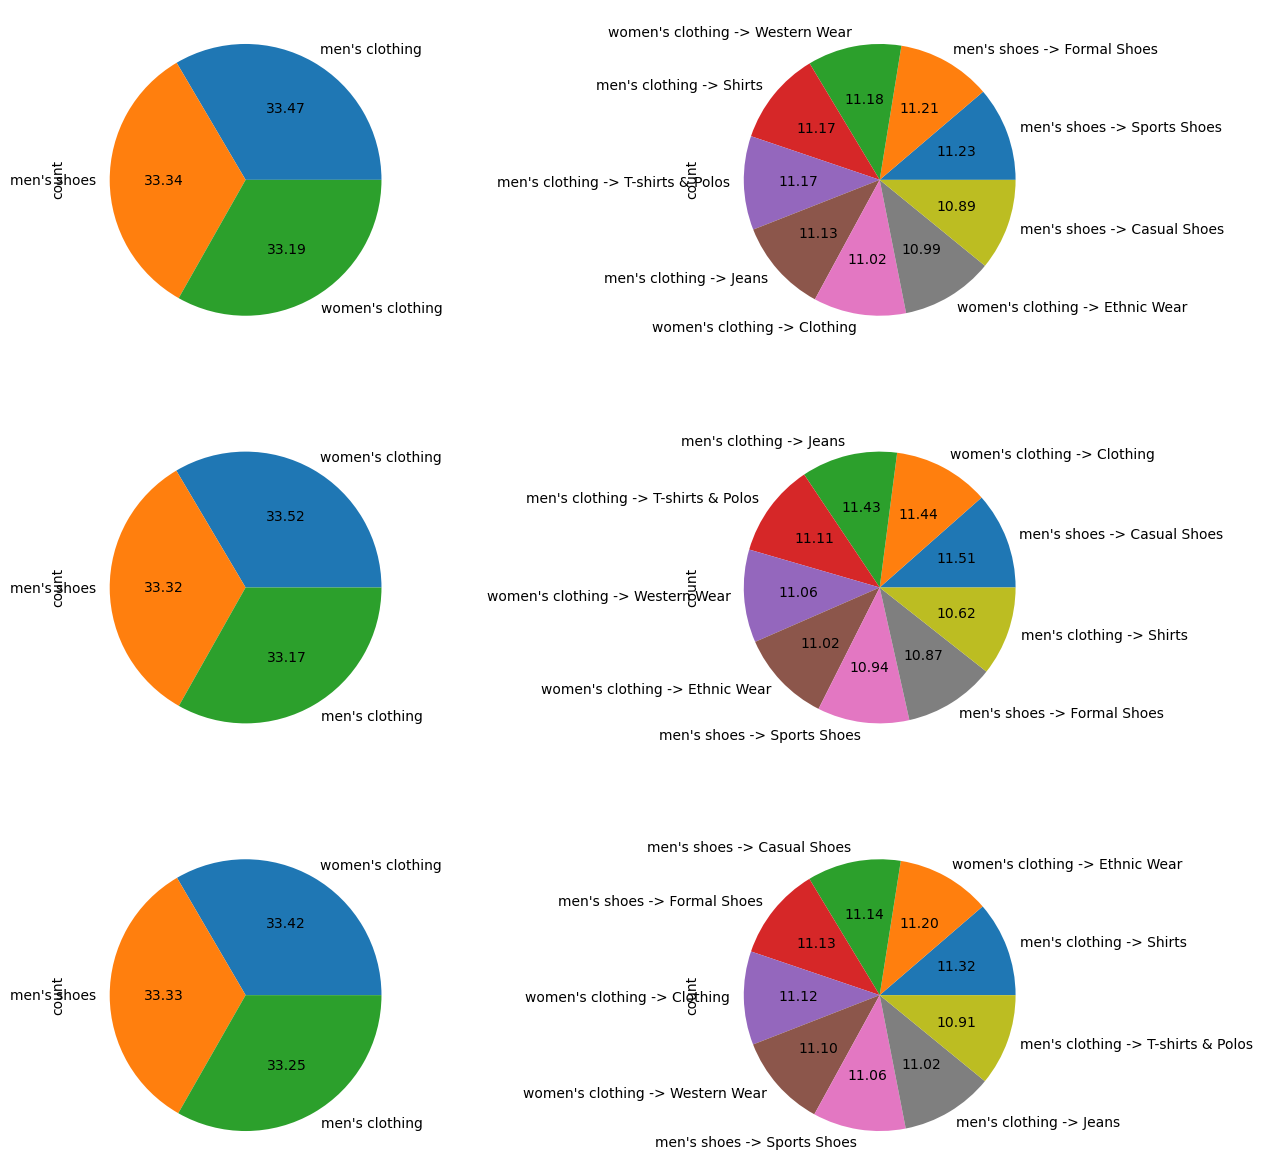

In [48]:
amazon_data = experimental_datasets.load_amazon_data('../../datasets/shopping/local/AmazonProducts2023/train_test_split/')

Split: train, Number of products: 5438, Number of non-empty descriptions: 2179
Split: val, Number of products: 1360, Number of non-empty descriptions: 541
Split: test, Number of products: 2913, Number of non-empty descriptions: 1092


c:\Users\mohitvyas\MyDesktop\ml_practice\nlp\neural_gen_lms\src\experimental_datasets.py:102: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(); plt.show()


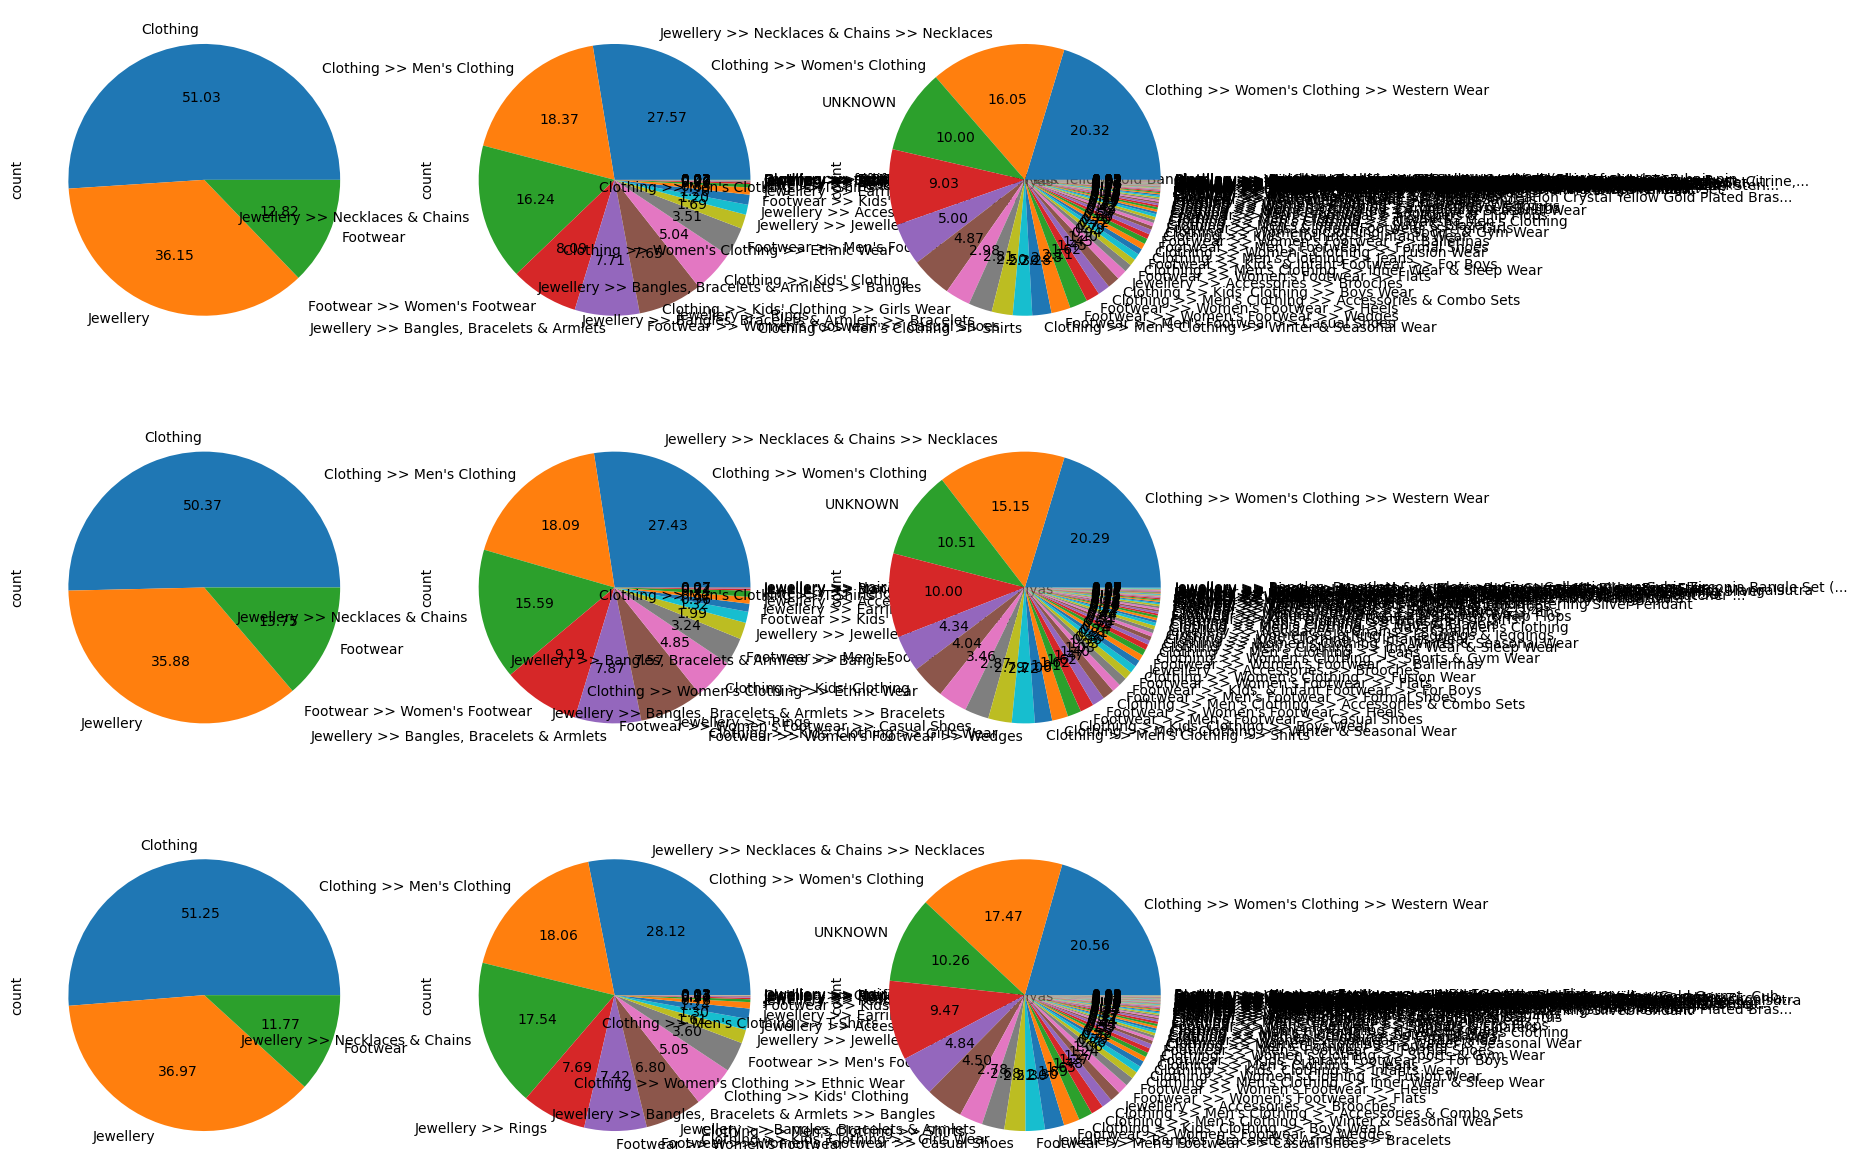

In [49]:
flipkart_data = experimental_datasets.load_flipkart_data('../../datasets/shopping/local/FlipkartEcommerce/train_test_split/')

In [50]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Add a new padding token if it doesn't exist
if tokenizer.pad_token is None:
    print ("Adding padding token")
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
gpt2_vocab = tokenizer.get_vocab()
print (f"Vocab size: {len(gpt2_vocab)}")
gpt2_id_to_token = {v: k for k, v in gpt2_vocab.items()}

Adding padding token
Vocab size: 50258


In [52]:
dataset_to_info = {
    'flipkart': {
        'data': flipkart_data, 
        'configs': {  # share these configs across all models
            'maxlen': 300, 
        },
    },
    'amazon': {
        'data': amazon_data, 
        'configs': {  # share these configs across all models
            'maxlen': 50,
        }
    },
}

In [53]:
# tokenize the data for each split and dataset
for dataset in dataset_to_info:
    configs = dataset_to_info[dataset]['configs']
    max_len = configs['maxlen']
    for split, data in dataset_to_info[dataset]['data'].items():
        print (f"Tokenizing {dataset} {split} data")
        sentences = data['raw_data']['lm_prediction_targets'].to_list()
        tokenized_and_padded_sentences = []
        lm_target_input_ids = []
        for sentence in tqdm(sentences, desc=f"Tokenizing {dataset} {split} data"):
            input_ids = tokenizer.encode(sentence, max_length=max_len, padding=False, truncation=True)
            input_ids = [tokenizer.eos_token_id] + input_ids + [tokenizer.eos_token_id]
            tokens = tokenizer.convert_ids_to_tokens(input_ids)
            tokenized_and_padded_sentences.append(tokens)
            lm_target_input_ids.append(input_ids)
        data['lm_target_tokens'] = tokenized_and_padded_sentences
        data['lm_target_input_ids'] = lm_target_input_ids

Tokenizing flipkart train data


Tokenizing flipkart train data:   0%|          | 0/5438 [00:00<?, ?it/s]

Tokenizing flipkart val data


Tokenizing flipkart val data:   0%|          | 0/1360 [00:00<?, ?it/s]

Tokenizing flipkart test data


Tokenizing flipkart test data:   0%|          | 0/2913 [00:00<?, ?it/s]

Tokenizing amazon train data


Tokenizing amazon train data:   0%|          | 0/96526 [00:00<?, ?it/s]

Tokenizing amazon val data


Tokenizing amazon val data:   0%|          | 0/24132 [00:00<?, ?it/s]

Tokenizing amazon test data


Tokenizing amazon test data:   0%|          | 0/51710 [00:00<?, ?it/s]

In [54]:
# save vocab, ngram counts for each dataset

for dataset in dataset_to_info:
    print (f"Dataset: {dataset}")
    # train tokens
    tokenized_and_padded_sentences = dataset_to_info[dataset]['data']['train']['lm_target_tokens']
    # calculate vocab
    vocab = Vocabulary(flatten(tokenized_and_padded_sentences), unk_cutoff=2)
    print (f"Vocab size: {len(vocab)}")

    ngram_counts = NgramCounter()
    for sentence in tqdm(tokenized_and_padded_sentences, desc=f'Counting ngrams in {dataset} train data'):
        ngram_counts.update([everygrams(vocab.lookup(sentence), max_len=5)])
    
    assets = {
        'vocab': vocab,
        'ngram_counts': ngram_counts,
    }
    dataset_to_info[dataset]['assets'] = assets

Dataset: flipkart
Vocab size: 7926


Counting ngrams in flipkart train data:   0%|          | 0/5438 [00:00<?, ?it/s]

Dataset: amazon
Vocab size: 11962


Counting ngrams in amazon train data:   0%|          | 0/96526 [00:00<?, ?it/s]

In [55]:
# fit witten-bell n-gram model and compute perplexity for each dataset and split
order = 5

for dataset in dataset_to_info:
    print (f"Dataset: {dataset}")
    vocab = dataset_to_info[dataset]['assets']['vocab']
    ngram_counts = dataset_to_info[dataset]['assets']['ngram_counts']
    model = lm.WittenBellInterpolated(order, vocabulary=vocab, counter=ngram_counts)

    for split, data in dataset_to_info[dataset]['data'].items():
        print (f"\tSplit: {split}")
        tokenized_and_padded_sentences = data['lm_target_tokens']
        eval_ngrams = []
        for sentence in tokenized_and_padded_sentences:
            tokens = vocab.lookup(sentence)
            for i in range(1, len(tokens)):
                eval_ngrams.append(tokens[max(0, i-order+1):i+1])
        perplexity = model.perplexity(eval_ngrams)
        print (f"\tPerplexity: {perplexity}")
        data['metrics'] = {
            'ngram_lm': {
                'perplexity': perplexity,
            }
        }
    print ("------------------------------------------")

    # generate 10 sentences using the trained model
    print ("\tGenerating 10 sentences using the trained model\n")
    for i in range(10):
        context = tokenizer.convert_ids_to_tokens([tokenizer.eos_token_id])
        end_token = context[0]
        for _ in range(40):
            next_word = model.generate(text_seed=context)
            context.append(next_word if next_word != '<UNK>' else '[PAD]') # <UNK> is not in the gpt2 vocab so replace with [PAD] for display purposes
            if next_word == end_token:
                break
        # translate context back to sentence
        context = tokenizer.decode(tokenizer.convert_tokens_to_ids(context))
        print (f"Sentence {i}: {context}\n")
    print ("------------------------------------------")

Dataset: flipkart
	Split: train
	Perplexity: 1.5106299217008496
	Split: val
	Perplexity: 11.570697602953318
	Split: test
	Perplexity: 10.47164600444428
------------------------------------------
	Generating 10 sentences using the trained model

Sentence 0: <|endoftext|>BlueStone The[PAD] White Gold Diamond 18 K Ring <|endoftext|>

Sentence 1: <|endoftext|>Fayon Floral Alloy Necklace <|endoftext|>

Sentence 2: <|endoftext|>Martini Women's Sheath Dress <|endoftext|>

Sentence 3: <|endoftext|>BlueStone The Suneha Yellow Gold Diamond, Pearl 14K White Gold 14 K Ring Price: Rs. 1,399 Patent leather, padded insole. Elegant style and feminine charm ex

Sentence 4: <|endoftext|>[PAD]key And Friends Casual Short Sleeve Solid Women's Top <|endoftext|>

Sentence 5: <|endoftext|>Hi Look Alloy Necklace <|endoftext|>

Sentence 6: <|endoftext|>Orange and Orchid Women's Shrug Details Sleeve 3/4th Gender: For Her Item Type: Kurti Color: Deep Pink Material: Cambric Cotton Specialty: Denim Printed Design


In [56]:
# save the dataset_to_info for later use
with open('local/model_comparison/dataset_to_info.pkl', 'wb') as f:
    pickle.dump(dataset_to_info, f)